model loading
Validation accuaracy 45.556	
CM not normalized [[891.  83.  21.  11.  88.  60.   2.]
 [ 98. 745.  46.  46.  84. 172.   5.]
 [101. 225. 101.  23. 196. 199.   1.]
 [ 61. 208.  10.  19. 175. 131.   4.]
 [ 98.  83.  77.  27. 723. 164.  10.]
 [106. 153.  44.  97. 174. 721.   0.]
 [ 93. 235.  23.  93.  57. 222.   3.]]


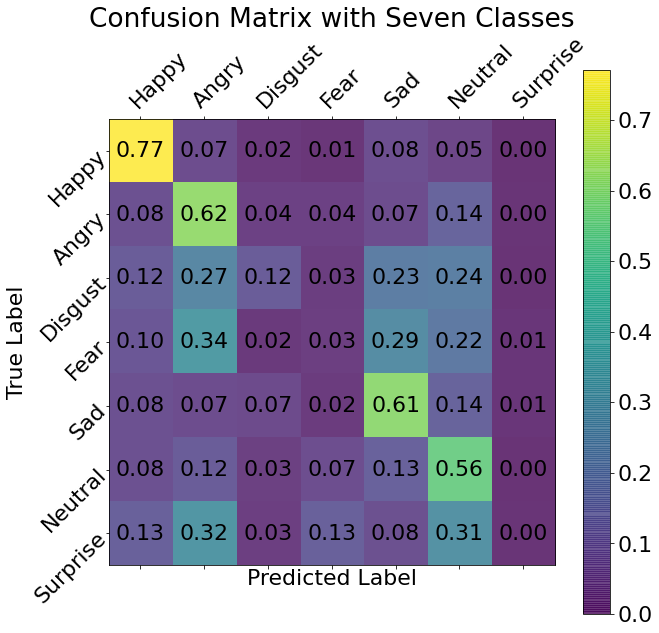

In [13]:
import cv2
import numpy as np
import os
import time

import torchvision.transforms as transforms
import torch
import matplotlib
import load
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
from PIL import Image
import torch.nn as nn
import math
init=[]
framesave=[]
peporcessing=[]
net=[]
totaltime=[]

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Network definition; convolution process
#in_planes: input size; out_planes: output size; kernel_size: the mid layer (constructed by the W); stride: nb of skipped pixels; padding: how to treat the missing pixels; bias: constant values that we add or not
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
def drawCM(confusion_matrix,classes):
    matplotlib.rcParams.update({'font.size': 22})
    fig, ax = plt.subplots(1,figsize=(10,10))
    ax.title.set_text('Confusion Matrix with Seven Classes')
    temp=ax.matshow(confusion_matrix,alpha=0.8)
    fig.colorbar(temp)
    ax.set_xticks(np.arange(len(list(classes.keys()))))
    ax.set_yticks(np.arange(len(list(classes.keys()))))

    ax.set_xticklabels(list(classes.keys()))
    ax.set_yticklabels(list(classes.keys()))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for (i, j), z in np.ndenumerate(confusion_matrix):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
    plt.savefig("cf3.jpeg",bbox_inches='tight')
    plt.show()
    

def create_confusion_matrix(y_true, y_pred):   
    numberOfClasses=7
    #print("number of Classes",numberOfClasses)
    score = [0] * numberOfClasses
    #print("ytrue",y_true)
    #print("ypred",y_pred)
    confusion_matrix = np.zeros((numberOfClasses, numberOfClasses))
    count=[0]*numberOfClasses
    
    #print("len1",len(y_true))

    
    for idx in range(len(y_true)):
        #print(y_true[idx])
        
        target = int(y_true[idx])
        #print("target",target)
        
        count[target]+=1
        max_value = max(y_pred[idx])

        output = y_pred[idx].index(max_value)

        
        #print("output",output)
        
        confusion_matrix[target][output] += 1


    print("CM not normalized",confusion_matrix)

    #if(not binary):
    #    ChangeCM(confusion_matrix,classes,mapping)
    #print("vector",np.array(count))
    confusion_matrix= confusion_matrix / np.array(count)[:,None]
    #print("confusion matrix normalized",confusion_matrix)
    classes={"Happy": 0,"Angry": 1,"Disgust": 2,"Fear": 3,"Sad": 4,"Neutral": 5,"Surprise": 6}
    drawCM(confusion_matrix,classes)
#define a block
class BasicBlock(nn.Module):
    expansion = 1
#block: convolution then batch normalization then relu
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU()
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    #residual block equation
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

#define the structure
class ResNet_AT(nn.Module):
    def __init__(self, block, layers,featureVectoreSize):
        super(ResNet_AT, self).__init__()
        self.inplanes = 64
        #convolution then batch normalization then relu without creating a block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        #max pooling: set the kernel and get the max value
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        #defining the layers (64,128,256 are the output size)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, featureVectoreSize, layers[3], stride=2)
        #get the average pooling
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier=nn.Linear(512,7)
        #initials weights based on a normal distribution
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    #creating layers and each layer has some blocks then make sure that input and output size of consecutive blocks are equal
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        #print(x.size())
        #change dimention order
        x=x.permute(0,4,1,2,3)
        #check each dimension size
        batch_size, seqlen, nc, h, w = x.size()
        #combine the batch size and sequence lenght together
        x = x.reshape(-1, nc, h, w)

        #apply all the above to get the result (emotion)
        f = self.conv1(x)
        f = self.bn1(f)
        f = self.relu(f)
        f = self.maxpool(f)
        f = self.layer1(f)
        f = self.layer2(f)
        f = self.layer3(f)
        f = self.layer4(f)
        f = self.avgpool(f)

        #reduce the 30 values to 10 (each value has 3 emotion scores)
        out = f.reshape(batch_size, seqlen, -1)
        #average the result on the 3 images from the same video
        out=out.mean(1)
        #
        out=self.classifier(out)
        return out

#allow to load the weights of the model
def model_parameters(_structure, _parameterDir):
    #checkpoint: a python dictionary where the weights are saved
    checkpoint = torch.load(_parameterDir)
    #state_dict: are the weights
    pretrained_state_dict = checkpoint['state_dict']
    model_state_dict = _structure.state_dict()

    for key in pretrained_state_dict:
        if ((key == 'module.fc.weight') | (key == 'module.fc.bias')):
            pass
        else:
            model_state_dict[key.replace('module.', '')] = pretrained_state_dict[key]

    #loading the weights
    _structure.load_state_dict(model_state_dict)
    #load them on the gpu if exists
    if torch.cuda.is_available():
        model = torch.nn.DataParallel(_structure).cuda()
    else:
        model = torch.nn.DataParallel(_structure)

    return model

#define which basic block we need to use; the nb of blocks per layer; nb of layers; output size(stucture)
def resnet18_at(featureVectoreSize, **kwargs):
    # Constructs base a ResNet-18 model.
    model = ResNet_AT(BasicBlock, [2, 2, 2, 2],featureVectoreSize, **kwargs)
    return model


idfolder=0

idpath="path"+str(idfolder)
folder="saveVids"

pathToSave=os.path.join(folder,idpath)

if not os.path.exists(pathToSave):
    os.makedirs(pathToSave)

idImg=0


#create the network
model=resnet18_at(512)

#load the network weights
state_dict = torch.load('network_weigths.zip',map_location=torch.device('cpu'))
#print(state_dict.keys())
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()

for k, v in state_dict.items():
    type = k[:7] # remove `module.`
    if(type=='module.'):
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    #else:
    #    new_state_dict[k] = v
        
model.load_state_dict(new_state_dict)
print("model loading")
if torch.cuda.is_available():
    model.cuda()

#evaluating not training
model.eval()

transformValidation=transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
def discreteAccuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)  # first position is score; second position is pred.
    pred = pred.t()  # .t() is T of matrix (256 * 1) -> (1 * 256)
    correct = pred.eq(target.view(1, -1).expand_as(pred))  # target.view(1,2,2,-1): (256,) -> (1, 2, 2, 64)

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))

    return res[0]
def val(val_loader, model,classes):
    
    lossesVal = load.AverageMeter()
    accuaracyVal = load.AverageMeter()

    #tell the code that we don't need to change the weight
    model.eval()
    #tell the code to not compute the gradiant
    storedPredictions=[]
    storedLabels=[]
    with torch.no_grad():
        for i, (input_var, target_var,path,index) in enumerate(val_loader):          
            target_var = target_var.float().to(DEVICE)
        
            input_var=torch.stack(input_var,4)
           
            input_var = input_var.to(DEVICE)
            pred_score = model(input_var)

            acc_iter = discreteAccuracy(pred_score.data, target_var)
            
            accuaracyVal.update(acc_iter, input_var.size(0))

            if i == (len(val_loader)-1):
                print('Validation accuaracy {accuaracy.avg:.3f}\t'
                    .format(accuaracy=accuaracyVal))
    
            storedPredictions.extend(torch.round(pred_score).tolist())
            storedLabels.extend(target_var.tolist())
            
    create_confusion_matrix(storedLabels, storedPredictions)
    return accuaracyVal.avg,lossesVal.avg

batchsize_train=64
numberOfFrames=3
batchsize_eval=32
transformTrain=transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(),transforms.RandomAffine(10, translate=[0.1,0.1], scale=[0.9, 1.25], shear=0.01), transforms.ToTensor()])
#get the image and apply the data augmentation process by resizing it to 224*224; tensor: array in pytoch
transformValidation=transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

cat2Label={ "Happy": 0,"Angry": 1,  "Disgust": 2, "Fear": 3,"Sad": 4,"Neutral": 5,"Surprise": 6}

root_train = './data/face/train_afew'
list_train = './data/txt/afew_All.txt'

root_eval = './data/face/val_afew'
list_eval= './data/txt/afew_eval.txt'
# load the data set
train_loader, val_loader = load.frames3average(root_train, list_train, batchsize_train, root_eval, list_eval, batchsize_eval,numberOfFrames,cat2Label, transformTrain,transformValidation)


validationAccuaracy,lossValidation = val(val_loader, model,cat2Label)
classes={"Happy": 0,"Angry": 1,"Disgust": 2,"Fear": 3,"Sad": 4,"Neutral": 5,"Surprise": 6}